In [85]:
import matplotlib
from tqdm import tqdm
import sys
sys.path.append('..')
from scipy import signal, stats, io
from neurolib.models.wc import WCModel
from task_fc_simulation.onset_design_model import WCOnsetDesign, HRF
from task_fc_simulation.read_utils import read_onsets_from_input
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 12
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Bold simulation with  using the Balloon-Windkessel model


The Balloon-Windkessel model assumes that the BOLD signal is a static nonlinear function of the normalized total deoxyhemoglobin voxel content, normalized venous volume, resting net oxygen extraction fraction by the capillary bed, and resting blood volume fraction. 

The BOLD signal [(Friston et all, 2003)](https://doi.org/10.1016/S1053-8119(03)00202-7) is taken to be a static nonlinear function of volume and deoxyhemoglobin
that comprises a volume-weighted sum of extra- and intravascular signals. For the $i_{th}$ region, neuronal activity $Z_i$ causes an increase in a vasodilatory signal $X_i$ that is subject to autoregulatory
feedback. Inflow $F_i$ responds in proportion to this
signal with concomitant changes in blood volume $V_i$ and
deoxyhemoglobin content $Q_i$

$$ \frac{d(X_i)}{dt} = Z_i-k*X_i-\gamma_i(F_i-1) \\
\frac{d(F_i)}{dt}  = X_i \\
\tau \frac{d(V_i)}{dt} = F_i-V_i^{1/\alpha} \\
\tau\frac{d(Q_i)}{dt} = F_i*(1-(1-\rho)^{1/F_i})/\rho_i - V_i^{1/\alpha-1}Q_i$$

$$y_i =V_0*(k_1(1-Q_i)+k_2(1-\frac{Q_i}{V_i}+k_3*(1-V_i))) $$

| Parameter | Description                        | Prior mean   | Prior variance |
|-----------|------------------------------------|--------------|----------------|
| k         | rate of signal decay               | 0.65 per sec | 0.015          |
| gamma     | rate of flow dependant elimination | 0.41 per sec | 0.002          |
| tau       | Hemodynamic transit time           | 0.98 s       | 0.0568         |
| alpha     | Grubb's exponent                   | 0.32         | 0.0015         |
| rho       | Resting oxygen extraction fraction | 0.34         | 0.0024         |
| V_0       | Resting blood volume fraction      | 0.02         |                |
| k1        |                                    | 7*rho        |                |
| k2        |                                    | 2            |                |
| k3        |                                    | 2*rho-0.2    |                |

## Convolution of simple task design

Input parameters:
 - N (int): Number of nodes (for each node could be node specific design) 
 - onsets (list of list of int or list): onset list for each region, for example [10, 12, 15], N lists
 - duration (float or list of lists): duration of each task (in seconds)
 - last_rest (float): duration of the last rest part, in seconds
 - dt (float): sampling rate for activations, in ms (!!!)
 - TR (float): sampling rate for BOLD (in seconds)(!!!)
 - normalize_max(float): scaling factor for activation, multiplied before convolution with bold 
 
### Toy example for two nodes  

In [86]:
N=2
first_rest = 6
onsets = [[5, 14, 25], [10, 20]]
hrf = HRF(N, dt=10, TR=1, normalize_max=0.5)
local_activation = hrf.create_task_design_activation(onsets, duration=2,
                                                             first_rest=first_rest, last_rest=5)
#if None: default values from table will be setted
bw_params = {"rho": 0.34, "alpha": 0.32, "V0": 0.02, "k1_mul": None,
                     "k2": None, "k3_mul": None, "gamma": None, "k": None, "tau":None}
hrf.bw_convolve(local_activation, append=False, **bw_params)

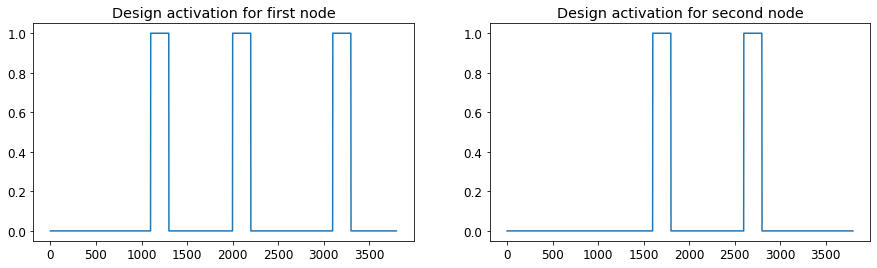

In [87]:
fig, axs = plt.subplots(1, 2, figsize = (15,4))
axs[0].plot(local_activation[0]); axs[0].set_title("Design activation for first node");
axs[1].plot(local_activation[1]); axs[1].set_title("Design activation for second node");

In [88]:
local_activation.shape, hrf.BOLD.shape

((2, 3800), (2, 38))

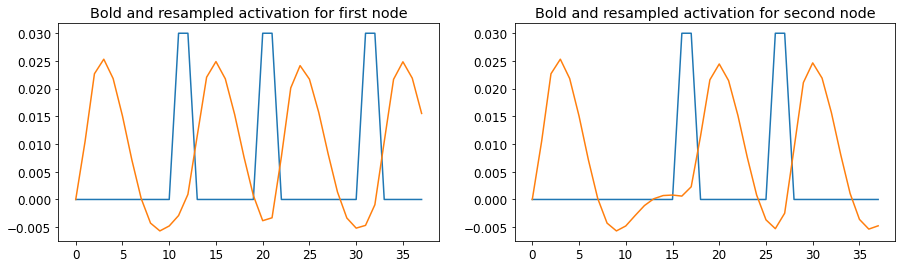

In [89]:
fig, axs = plt.subplots(1, 2, figsize = (15,4))
axs[0].plot(0.03*local_activation[0,::100]);
axs[0].plot(hrf.BOLD[0]); axs[0].set_title("Bold and resampled activation for first node");
axs[1].plot(0.03*local_activation[1,::100]);
axs[1].plot(hrf.BOLD[1]); axs[1].set_title("Bold and resampled activation for second node");

## Example with the real onsets

 - realization additive local activity TaskDesign*HRF

In [90]:
mat_path = '../data/SOTs_1.5s_duration.mat'
input_data = io.loadmat(mat_path)

In [91]:
print(input_data.keys())
print("Additional activation: ",input_data["activations"])

dict_keys(['__header__', '__version__', '__globals__', 'activations', 'durations', 'names', 'onsets', 'rest_matrix', 'task_matrices'])
Additional activation:  [[array([[1, 1, 0]], dtype=uint8) array([[0, 1, 1]], dtype=uint8)]]


In [92]:
input_data["durations"]

array([[array([[1.5]]), array([[1.5]])]], dtype=object)

Here we have next additional local activation:
 - for first block: taskA
 - for second block: taskB+taskA
 - for third block: taskB

so we need to create onset list for all these blocks

In [93]:
onset_taskA = list(input_data['onsets'][0, 0].squeeze().round(2))
onset_taskB = list(input_data['onsets'][0, 1].squeeze().round(2))
onset_taskAB,_,_ = read_onsets_from_input(mat_path)
onset_taskAB = list(onsets_taskAB)

In [94]:
len([onset_taskA]*10+[onset_taskAB]*10+[onset_taskB]*10)

30

In [95]:
N=30
first_rest = 6
onsets = [onset_taskA]*(N//3)+[onset_taskAB]*(N//3)+[onset_taskB]*(N//3)
hrf = HRF(N, dt=10, TR=1, normalize_max=0.5)
local_activation = hrf.create_task_design_activation(onsets, duration=1.5,
                                                          first_rest=first_rest, last_rest=6)

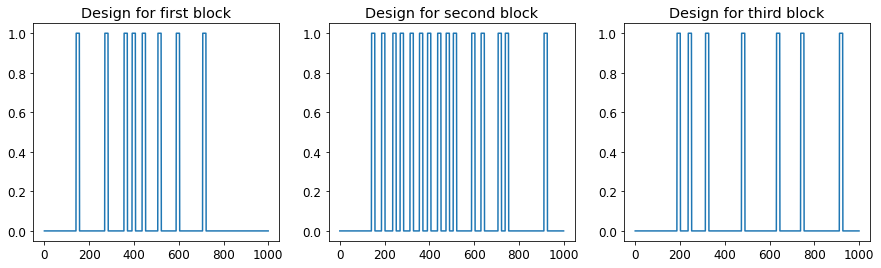

In [96]:
fig, axs = plt.subplots(1, 3, figsize = (15,4))
axs[0].plot(local_activation[0, :10000:10]); axs[0].set_title("Design for first block");
axs[1].plot(local_activation[10,:10000:10]); axs[1].set_title("Design for second block");
axs[2].plot(local_activation[20,:10000:10]); axs[2].set_title("Design for third block");

In [97]:
#if None: default values from table will be setted
bw_params = {"rho": 0.34, "alpha": 0.32, "V0": 0.02, "k1_mul": None,
                     "k2": None, "k3_mul": None, "gamma": None, "k": None, "tau":None}
hrf.bw_convolve(local_activation, append=False, **bw_params)

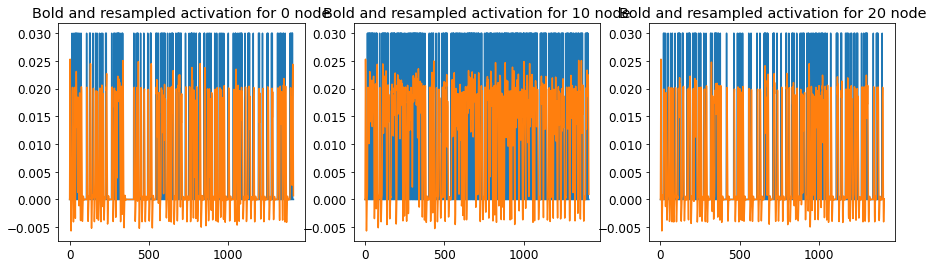

In [98]:
fig, axs = plt.subplots(1, 3, figsize = (15,4))
node_ids = [0,10,20]
for i in range(3):
    axs[i].plot(0.03*local_activation[node_ids[i],::100]);
    axs[i].plot(hrf.BOLD[node_ids[i]]); axs[i].set_title(f"Bold and resampled activation for {node_ids[i]} node");
